# Libreta con el objetivo de predecir sobre un conjunto de datos

In [67]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

In [3]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

In [4]:
#Cargamos los datos
df_minsait = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_minsait.shape[0])
print("Número de variables: %d" % df_minsait.shape[1])

Tamaño del conjunto de datos:  103230
Número de variables: 55


In [5]:
def process_cadastral_quality(df):
    dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
    return df

def process_max_building_floor(df):
    df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
    return df

def assing_class(df):
    df['SUBCLASE'] = (df['CLASE'] == 'RESIDENTIAL').astype(int)
    
process_cadastral_quality(df_minsait)
process_max_building_floor(df_minsait)
assing_class(df_minsait)

In [6]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_minsait[df_minsait.columns[:-2]].copy()
y = df_minsait['SUBCLASE'].copy()

0.9810520197616972


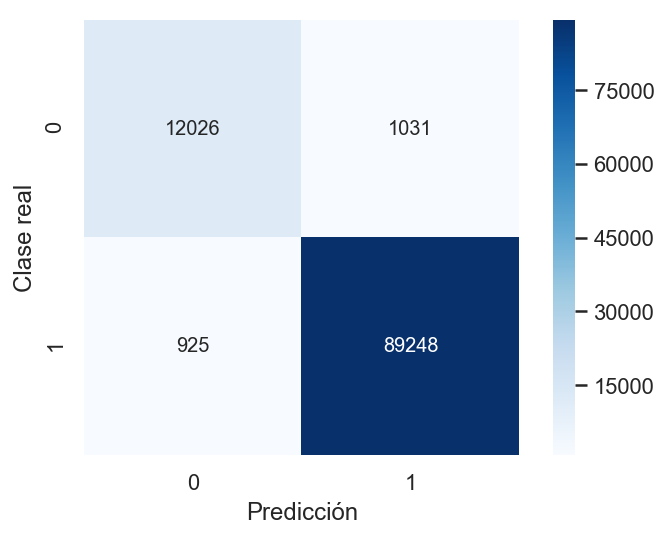

Resultados
Accuracy: 0.981
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     13057
           1       0.99      0.99      0.99     90173

    accuracy                           0.98    103230
   macro avg       0.96      0.96      0.96    103230
weighted avg       0.98      0.98      0.98    103230



In [68]:
#Cargamos el modelo y predecimos
model_bin = pickle.load(open('./models/binary_smote_15_03_xgboost_20_100.pkl', 'rb'))
result = model_bin.score(X, y)
print(result)
y_pred = model_bin.predict(X)
show_results(y, y_pred)
print(classification_report(y, y_pred))

Obtenicón de los regisrtros que no son residenciales

In [69]:
list_ids_no_residential = X[y_pred==0].index.tolist()

In [70]:
df_no_resident = df_minsait[df_minsait.index.isin(list_ids_no_residential)]
df_no_resident.shape

(12951, 56)

In [71]:
df_resident = df_minsait[~df_minsait.index.isin(list_ids_no_residential)]
y_resident = df_resident['CLASE']
display(df_resident.shape)

(90279, 56)

Predicción sobre los datos obtenidos del primer modelo

In [72]:
X_val = df_no_resident[df_no_resident.columns[:-2]].copy()
y_val = df_no_resident['CLASE'].copy()

In [73]:
#Cargamos el modelo y predecimos
model_bin = pickle.load(open('./models/multiclass_14_03.pkl', 'rb'))
result = model_bin.score(X_val, y_val)
print(result)
y_val_pred = model_bin.predict(X_val)

0.8173114045247472


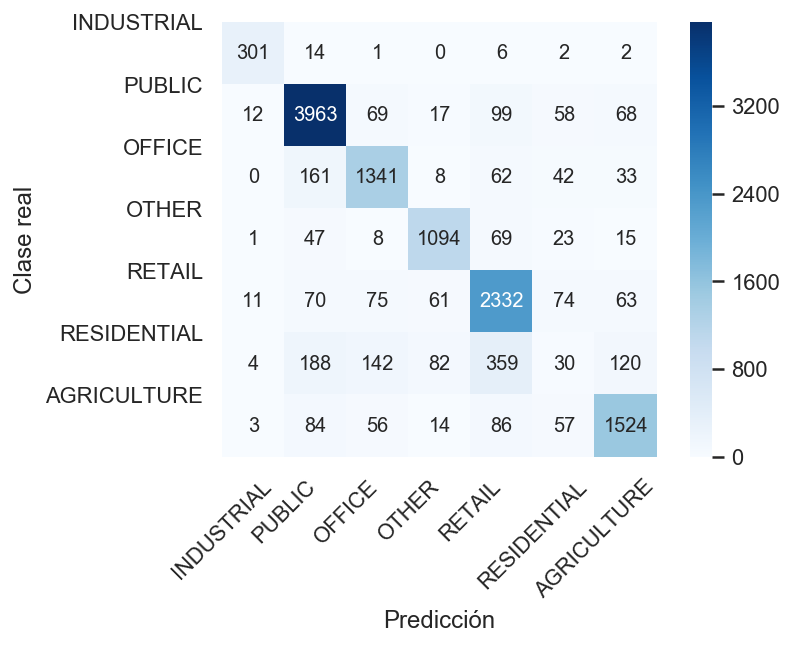

Resultados
Accuracy: 0.817
              precision    recall  f1-score   support

 AGRICULTURE       0.91      0.92      0.91       326
  INDUSTRIAL       0.88      0.92      0.90      4286
      OFFICE       0.79      0.81      0.80      1647
       OTHER       0.86      0.87      0.86      1257
      PUBLIC       0.77      0.87      0.82      2686
 RESIDENTIAL       0.10      0.03      0.05       925
      RETAIL       0.84      0.84      0.84      1824

    accuracy                           0.82     12951
   macro avg       0.74      0.75      0.74     12951
weighted avg       0.78      0.82      0.80     12951



In [74]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
plt.ylabel('Clase real')
plt.xlabel('Predicción');
target_names = y_val.unique()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names, rotation=0)
plt.show()
print("Resultados")
print('Accuracy: {}'.format(round(accuracy_score(y_val, y_val_pred), 3)))
print(classification_report(y_val, y_val_pred))

In [63]:
# Lo convertimos en serie para tener referenciado el ID
y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
all_data_pred = y_resident.append(y_no_resident)
accuracy_score(df_minsait['CLASE'], all_data_pred)

0.7615712486680228

In [64]:
df_minsait['CLASE'].tail(15)

ID
64F25387AC3C63C3    RESIDENTIAL
810E110DCF7D1629     INDUSTRIAL
FA71F6875DD2EFAB    RESIDENTIAL
C8ACB408BA3CD153    RESIDENTIAL
4FE64520669D13EB    RESIDENTIAL
047E562FD0DDFA2F    RESIDENTIAL
3B021797760C4602    RESIDENTIAL
D53A7AF361F49028    RESIDENTIAL
781CFBE5D41D360A    RESIDENTIAL
0F0A3D4DED862C11    RESIDENTIAL
C5FD596EB22DB167    RESIDENTIAL
A51D42F2EAB0E15E    RESIDENTIAL
9B75473FE6396523     INDUSTRIAL
3E566F8A461FDBA3    RESIDENTIAL
0E6F8A7388F1FF25    RESIDENTIAL
Name: CLASE, dtype: object

In [65]:
all_data_pred[df_minsait['CLASE'].tail(15).index]

ID
64F25387AC3C63C3    RESIDENTIAL
810E110DCF7D1629     INDUSTRIAL
FA71F6875DD2EFAB    RESIDENTIAL
C8ACB408BA3CD153     INDUSTRIAL
4FE64520669D13EB    RESIDENTIAL
047E562FD0DDFA2F    RESIDENTIAL
3B021797760C4602    RESIDENTIAL
D53A7AF361F49028    RESIDENTIAL
781CFBE5D41D360A    RESIDENTIAL
0F0A3D4DED862C11    RESIDENTIAL
C5FD596EB22DB167    RESIDENTIAL
A51D42F2EAB0E15E    RESIDENTIAL
9B75473FE6396523     INDUSTRIAL
3E566F8A461FDBA3    RESIDENTIAL
0E6F8A7388F1FF25    RESIDENTIAL
dtype: object

---

# Prediccion de los valores a predecir junto con la generación del fichero

In [17]:
#Cargamos los datos
df_minsait_estimate = pd.read_csv('data/Estimar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_minsait_estimate.shape[0])
print("Número de variables: %d" % df_minsait_estimate.shape[1])
if df_minsait_estimate.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
df_minsait_estimate.head()

Tamaño del conjunto de datos:  5618
Número de variables: 54
El índice es único.


,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID
ID,,,,,,,,,,,,,,,,,,,,,
44198C2A811A4DF4,2200905624,165480229,0.000001,445.999637,634.001172,780.000568,902.004053,1025.997009,1157.997681,1304.999585,...,2545.997754,6803.875107,283.593030,0.046741,0.014588,0.011298,0.774503,1994,5.0,4
216F638609E0E39E,2207436564,165625751,0.000000,385.000995,580.005762,737.004449,873.996460,1005.998779,1141.001758,1296.997083,...,2220.990137,5544.670485,357.712450,0.378483,0.041085,0.025753,0.626835,1968,8.0,3
FFFCEFB11E257364,2200313961,165752898,0.000000,343.996613,567.010620,745.995483,900.997925,1051.995361,1200.006226,1370.990234,...,2421.002441,8827.104856,160.979017,0.306545,0.034637,0.054977,1.587207,1968,5.0,7
596C5C8CE10BCF,2199220382,166288192,0.000000,173.999956,218.000000,261.999713,315.999951,408.000565,560.000500,700.697351,...,2752.005786,7734.759269,9088.678448,0.338955,0.006846,0.005448,0.795725,1993,6.0,6
F931B9FA2A8641D1,2209143550,165253334,0.000007,588.002014,738.999451,848.001282,954.000244,1074.000183,1228.998291,1416.999817,...,2712.997681,7435.991490,994.424368,0.581476,0.036470,0.016033,0.439638,1964,4.0,7


In [19]:
def estimate(df):
    def process_cadastral_quality(df):
        dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
        return df

    def process_max_building_floor(df):
        df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
        return df
    
    process_cadastral_quality(df)
    process_max_building_floor(df)
    
    X = df.copy()
    
    #Cargamos el modelo y predecimos
    model_bin = pickle.load(open('./models/binary_14_03.pkl', 'rb'))
    y_pred = model_bin.predict(X)
    
    list_ids_no_residential = X[y_pred==0].index.tolist()
    y_resident = pd.Series(index=X[y_pred==1].index, data='RESIDENTIAL')
    df_no_resident = df[df.index.isin(list_ids_no_residential)]
    
    #Modelo final
    X_val = df_no_resident.copy()
    
    model_multi = pickle.load(open('./models/multiclass_14_03.pkl', 'rb'))
    y_val_pred = model_multi.predict(X_val)
    
    # Lo convertimos en serie para tener referenciado el ID
    y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
    all_data_pred = y_resident.append(y_no_resident)
    
    solution = all_data_pred[df.index].reset_index()
    #print(solution)
    #print(all_data_pred.tail())
    
    #Generamos el fichero obtenido de la prediccion con ambos modelos
    np.savetxt('./outputs/Estimar_CMBC_0_71_14_03.txt', solution.values, fmt='%s', delimiter="|", header="ID|CLASE", encoding='utf-8')
    
    print('Fichero generado correctamente')
    plt.figure(figsize=(12,6))
    sns.countplot(all_data_pred[df.index], order=list_class_order)

Fichero generado correctamente


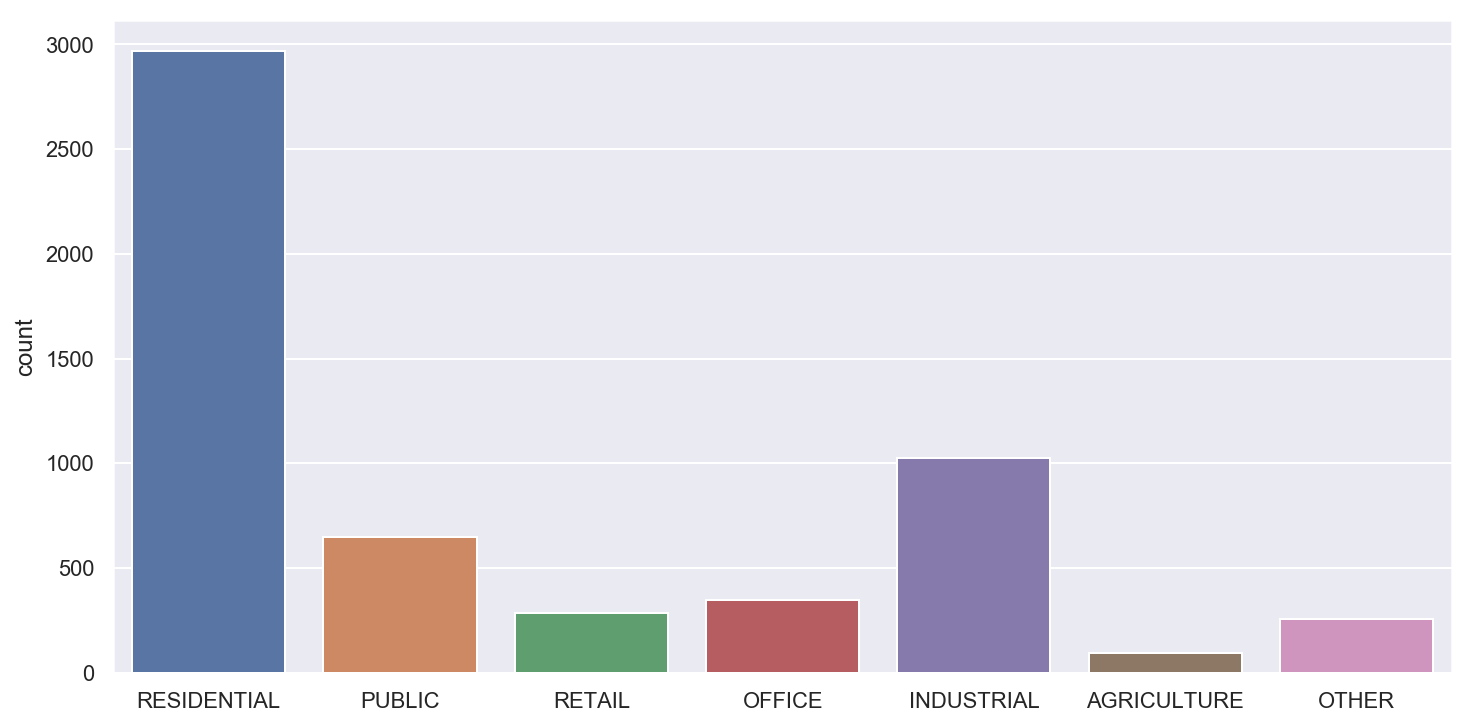

In [20]:
estimate(df_minsait_estimate)

In [26]:
df_concurso = pd.read_csv('./outputs/Estimar_CMBC_0_70_no_PCA.txt', delimiter='|', encoding='utf-8', index_col='ID')
df_now = pd.read_csv('./outputs/Estimar_CMBC_0_71_14_03.txt', delimiter='|', encoding='utf-8', index_col='ID')

In [27]:
display(df_concurso.head())
display(df_now.head())

,CLASE
ID,
44198C2A811A4DF4,PUBLIC
216F638609E0E39E,RESIDENTIAL
FFFCEFB11E257364,RESIDENTIAL
596C5C8CE10BCF,OFFICE
F931B9FA2A8641D1,OTHER


,CLASE
ID,
44198C2A811A4DF4,PUBLIC
216F638609E0E39E,RESIDENTIAL
FFFCEFB11E257364,RESIDENTIAL
596C5C8CE10BCF,OFFICE
F931B9FA2A8641D1,OTHER


In [28]:
accuracy_score(df_concurso, df_now)

1.0